# Preparations

<b>Load Libraries</b>

In [6]:
# udf 
import os, sys
cwd = os.getcwd()
os.chdir('../')
path_to_src = os.getcwd()
if path_to_src not in sys.path:
    sys.path.append(path_to_src)
os.chdir(cwd)
##
from src.notebook.support import *
from src.mlflow.support import *

# others 
from warnings import simplefilter

<b>Load Dataset</b>

In [7]:
# materials
materials = prepare_data_to_train(path='../cache/data/cleaned.csv')

<b>MLflow</b>

In [8]:
# local server
mlflow.set_tracking_uri('http://127.0.0.1:5000/')
experiment_name = 'Feature engineering'
try:
    mlflow.create_experiment(name=experiment_name, artifact_location='cache/mlflow/runs/')
except:
    mlflow.set_experiment(experiment_name=experiment_name)

In [9]:
# tags
tags = {'pre_pro': None, 'base_model': None, 
        'feature_selection': 'false', 'beta_f': 2}

# metrics
metrics = {'avg_fbeta': None, 'val_fbeta': None}

# 1. Baseline Evaluation

In [16]:
# dtype's indexs separation
num_iters = materials['X_train'].shape[1]
num_idxes, cat_idxes = [], []
for i in range(num_iters):
    try:
        float(materials['X_train'][0, i])
        num_idxes.append(i)
    except:
        cat_idxes.append(i)

In [21]:
# warnings
simplefilter(action='ignore')

# base models
base_models = load_base_models()

# trasnformers
ct = ColumnTransformer([('num', SimpleImputer(strategy='mean'), num_idxes), 
                        ('cat', OneHotEncoder(drop='first', sparse_output=False), cat_idxes)])

# pipeline
pipelines = []
for name, model in base_models:
    pipeline = Pipeline([('trans', ct), 
                         (name, model)])
    pipelines.append((name, pipeline))

kfold_results = get_kfold_results(pipelines, materials['X_train'], materials['y_train'])

LR: 0.5576398777140695 (0.03318352891094596)
KNN: 0.4580758774508246 (0.03971523899930276)
SVM: 0.0 (0.0)
CART: 0.4877050998677607 (0.04100404352911018)
ET: 0.4866171256802644 (0.041132753594308756)
RF: 0.4988824774994805 (0.04005701433661895)
GB: 0.5334757398446867 (0.030294471597094256)
LGBM: 0.534500564541397 (0.03492077482020717)
XGB: 0.5346661648584246 (0.03996922328547825)


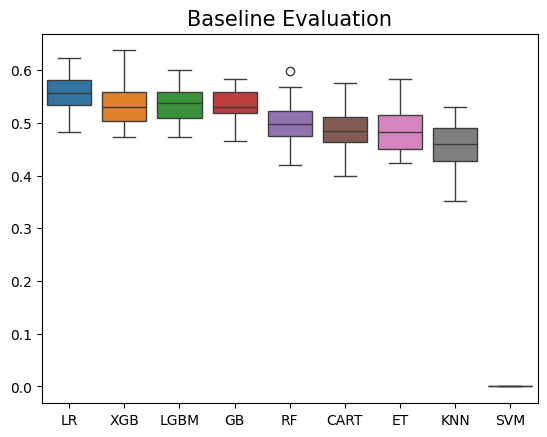

In [22]:
# plot kfold results
plot_kfold_results(kfold_results, 'Baseline Evaluation')

In [33]:
# mlflow
for name, pipeline in pipelines:
    ##
    pipeline.fit(materials['X_train'], materials['y_train'])
    val_predictions = pipeline.predict(materials['X_test'])
    val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                            beta=2)
    ##
    with mlflow.start_run():
        ### tags
        tags['pre_pro'] = 'si(mean)_ohe'
        tags['base_model'] = name
        mlflow.set_tags(tags)
        ###
        metrics['avg_fbeta'] = kfold_results[name].mean()
        metrics['val_fbeta'] = val_fbeta
        mlflow.log_metrics(metrics)
        ###
        mlflow.sklearn.log_model(artifact_path='model', 
                                 sk_model=pipeline)

In [13]:
# infer pip requirements
runs_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_ohe'"
)['run_id'].values[0]
pip_requirements = infer_pip_requirements(
    model_uri=f'runs:/{runs_id}/model', 
    flavor='sklearn'
)
pip_requirements.extend(['mlxtend==0.23.1'])
pip_requirements

['cloudpickle==3.0.0',
 'imbalanced-learn==0.12.3',
 'numpy==1.26.4',
 'psutil==6.0.0',
 'scikit-learn==1.5.1',
 'scipy==1.14.0',
 'mlxtend==0.23.1']

# 2. Scaling

<b>Standardization</b>

In [15]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

std = Node('std', StandardScaler())
std.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
std.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

left = [std, impute]
right = [ohe]

tree = InitBinaryTree(left, right)

In [16]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': '../cache/temp/model.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2),
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump sfs
dump_model(sfs, artifacts_path['feature_selector'])
## dump pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 21:16:31] Features: 1/19 -- score: 0.0
[2024-08-15 21:16:41] Features: 2/19 -- score: 0.004570383912248629
[2024-08-15 21:17:09] Features: 3/19 -- score: 0.49738784639863576
[2024-08-15 21:17:01] Features: 4/19 -- score: 0.5264335732277955
[2024-08-15 21:17:29] Features: 5/19 -- score: 0.542909965318185
[2024-08-15 21:17:21] Features: 6/19 -- score: 0.5497678892630741
[2024-08-15 21:17:31] Features: 7/19 -- score: 0.5582460302829307
[2024-08-15 21:17:59] Features: 8/19 -- score: 0.5615610489024462
[2024-08-15 21:18:08] Features: 9/19 -- score: 0.5628681460505737
[2024-08-15 21:17:58] Features: 10/19 -- score: 0.5623155556285856
[2024-08-15 21:18:07] Features: 11/19 -- score: 0.5626338770526481
[2024-08-15 21:18:17] Features: 12/19 -- score: 0.5603045058325551
[2024-08-15 21:18:26] Features: 13/19 -- score: 0.5609586299974395
[2024-08-15 21:18:33] Features: 14/19 -- score: 0.5533647558847675
[2024-08-15 21:18:58] Features: 15/19 -- score: 0.5510480115571118
[2024-08-15 21:1

In [19]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(y_true=materials['y_test'], y_pred=val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_std_ohe'
    tags['base_model'] = 'LR'
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### pipeline
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path,
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Power Transformation</b>

In [38]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('pwt', PowerTransformer(method='yeo-johnson'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), PowerTransformer(method='yeo-johnson')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [39]:
# warnings
simplefilter(action='ignore')

# artifacts path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2
)
sfs.fit(materials['X_train'], materials['y_train'])
## dump 
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 21:05:04] Features: 1/19 -- score: 0.33205662917330886
[2024-08-15 21:05:33] Features: 2/19 -- score: 0.4631664570441416
[2024-08-15 21:05:26] Features: 3/19 -- score: 0.4871570345784437
[2024-08-15 21:05:37] Features: 4/19 -- score: 0.5125746886280731
[2024-08-15 21:05:50] Features: 5/19 -- score: 0.5346209655946593
[2024-08-15 21:06:21] Features: 6/19 -- score: 0.5374959548243118
[2024-08-15 21:06:33] Features: 7/19 -- score: 0.5391840358485117
[2024-08-15 21:06:45] Features: 8/19 -- score: 0.5451007405000357
[2024-08-15 21:06:38] Features: 9/19 -- score: 0.5472338834636454
[2024-08-15 21:07:08] Features: 10/19 -- score: 0.5468365186453819
[2024-08-15 21:07:00] Features: 11/19 -- score: 0.5508034756035867
[2024-08-15 21:07:11] Features: 12/19 -- score: 0.5491666048484646
[2024-08-15 21:07:24] Features: 13/19 -- score: 0.545794584696017
[2024-08-15 21:07:35] Features: 14/19 -- score: 0.5416761873194678
[2024-08-15 21:07:44] Features: 15/19 -- score: 0.5376368223398625
[20

In [40]:
# mlflow
##
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_pwt_ohe'
    tags['base_model'] = 'LR'
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ### log
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(),
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

<b>Quantile Transformation</b>

In [10]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask], idxes[~mask]

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('qtt', QuantileTransformer(output_distribution='normal'))
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), QuantileTransformer(output_distribution='normal')))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [11]:
# warnings
simplefilter(action='ignore')

# artifacts_path
artifacts_path = {'feature_selector': '../cache/temp/feature_selector.pkl', 
                  'model': f'../cache/temp/model.pkl'}

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# pipeline
pipeline = Pipeline([('trans', transformers)] + base_model)

# sfs
sfs = SequentialFeatureSelector(
    estimator=pipeline, k_features='best', forward=True, 
    cv=RepeatedStratifiedKFold(n_splits=10, n_repeats=3), 
    scoring=make_scorer(fbeta_score, beta=2), 
    verbose=2

)
sfs.fit(materials['X_train'], materials['y_train'])
## dump
dump_model(sfs, artifacts_path['feature_selector'])
## pipeline
pipeline.fit(sfs.transform(materials['X_train']), materials['y_train'])
dump_model(pipeline, artifacts_path['model'])


[2024-08-15 21:12:49] Features: 1/19 -- score: 0.23117769727719326
[2024-08-15 21:13:19] Features: 2/19 -- score: 0.4601099404524146
[2024-08-15 21:13:30] Features: 3/19 -- score: 0.4920947282601149
[2024-08-15 21:13:23] Features: 4/19 -- score: 0.5065766770818684
[2024-08-15 21:13:34] Features: 5/19 -- score: 0.5316032148643207
[2024-08-15 21:14:03] Features: 6/19 -- score: 0.5475745038349216
[2024-08-15 21:14:14] Features: 7/19 -- score: 0.5469545783434232
[2024-08-15 21:14:25] Features: 8/19 -- score: 0.5429693441748864
[2024-08-15 21:14:36] Features: 9/19 -- score: 0.5488581149702809
[2024-08-15 21:14:27] Features: 10/19 -- score: 0.5457746783785271
[2024-08-15 21:14:37] Features: 11/19 -- score: 0.553499594352472
[2024-08-15 21:15:08] Features: 12/19 -- score: 0.5555010972616607
[2024-08-15 21:15:01] Features: 13/19 -- score: 0.5567733271458047
[2024-08-15 21:15:10] Features: 14/19 -- score: 0.5541153689486787
[2024-08-15 21:15:35] Features: 15/19 -- score: 0.555141723151836
[202

In [14]:
# mflow
## 
val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
##
with mlflow.start_run():
    ### tags
    tags['pre_pro'] = 'si(mean)_qtt_ohe'
    tags['base_model'] = 'LR'
    tags['feature_selection'] = 'true'
    mlflow.set_tags(tags)
    ### metrics
    metrics['avg_fbeta'] = sfs.k_score_
    metrics['val_fbeta'] = val_fbeta
    mlflow.log_metrics(metrics)
    ###
    mlflow.pyfunc.log_model(artifact_path='model', 
                            python_model=MLflowModel(), 
                            artifacts=artifacts_path, 
                            signature=infer_signature(materials['X_train']), 
                            pip_requirements=pip_requirements)

# 3. Factor Analysis

# 4. Resampling

In [21]:
# nodes
def scale_test(data: dict) -> tuple[list, list]:
    arr, idxes = data['X'], np.array(data['idxes'])
    mask = pd.isnull(arr[:, idxes]).sum(axis=0) == 0
    passed, failed = idxes[mask].tolist(), idxes[~mask].tolist()

    return passed, failed

def impute_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

def ohe_test(data: dict) -> tuple[list, list]:
    return data['idxes'], []

scale = Node('std', StandardScaler())
scale.test = scale_test

impute = Node('impute', make_pipeline(SimpleImputer(), StandardScaler()))
impute.test = impute_test
scale.next = impute

ohe = Node('ohe', OneHotEncoder(drop='first', sparse_output=False))
ohe.test = ohe_test

tree = InitBinaryTree([scale, impute], [ohe])

In [37]:
# data
run_id = mlflow.search_runs(
    filter_string="tags.base_model = 'LR' and tags.pre_pro = 'si(mean)_std_ohe'", 
    order_by=["metrics.val_fbeta DESC"]
)['run_id'].values[0]
path = mlflow.artifacts.download_artifacts(f"runs:/{run_id}/model/artifacts/feature_selector.pkl")
with open(path, 'rb') as f:
    sfs = cloudpickle.load(f)
    selected_X_train = sfs.transform(materials['X_train'])

In [41]:
# warnings
simplefilter(action='ignore')

# resamplers
resamplers = load_resammplers()

# base model
base_model = get_seleted_models(['LR'])

# transformers
transformers = SFS(tree)

# evaluation 
kfold_results = dict()
for name, resampler in resamplers:
    ##
    pipeline = [(name, Pipeline([('trans', transformers), (name, resampler)] + base_model))]
    cv_results = get_kfold_results(pipeline, selected_X_train, materials['y_train'])
    kfold_results.update(cv_results)
    ##
    _, pipeline = pipeline[0]
    pipeline.fit(selected_X_train, materials['y_train'])
    artifacts_path['model'] = f'../cache/temp/model.pkl'
    dump_model(pipeline, artifacts_path['model'])
    ## mlflow
    val_predictions = pipeline.predict(sfs.transform(materials['X_test']))
    val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                            beta=2)
    with mlflow.start_run():
        ### tags
        mlflow.set_tags({'pre_pro': f'si(mean)_std_ohe_{name.lower()}', 
                         'base_model': 'LR', 
                         'feature_selection': 'true', 
                         'beta_f': 2})
        ### metrics
        mlflow.log_metrics({'avg_fbeta': cv_results[name].mean(), 
                            'val_fbeta': val_fbeta})
        ### model
        mlflow.pyfunc.log_model(artifact_path='model', 
                                python_model=MLflowModel(), 
                                artifacts=artifacts_path, 
                                signature=infer_signature(materials['X_train']),
                                pip_requirements=pip_requirements)

ROS: 0.70049662984027 (0.025567693085054684)


SMOTE: 0.7016431796687628 (0.030763783188132453)


SMOTEENN: 0.739815021408516 (0.014950624192659108)


SMOTETomek: 0.7244381655349812 (0.02205703422581304)


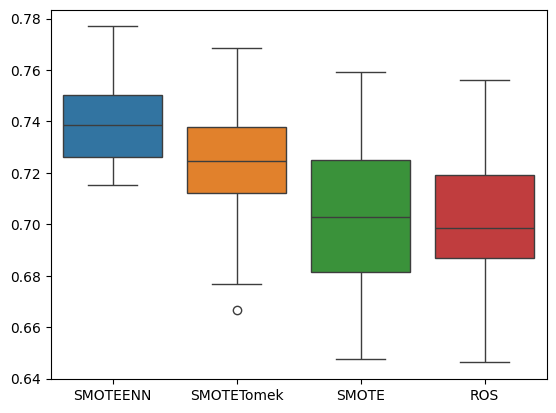

In [42]:
# plot
plot_kfold_results(kfold_results)

# 5. Finalize Model

In [43]:
# search runs
## notes: if using nodes, the function for the node should be present in memory 
run_id = mlflow.search_runs(
    filter_string="tag.pre_pro = 'si(mean)_std_ohe_smoteenn' and tags.base_model = 'LR'"
)['run_id'].values[0]
model = mlflow.pyfunc.load_model(f"runs:/{run_id}/model")

FBeta score: 0.7534443168771527 
Classification report: 
              precision    recall  f1-score   support

           0       0.96      0.54      0.69      1552
           1       0.42      0.94      0.58       561

    accuracy                           0.64      2113
   macro avg       0.69      0.74      0.64      2113
weighted avg       0.82      0.64      0.66      2113



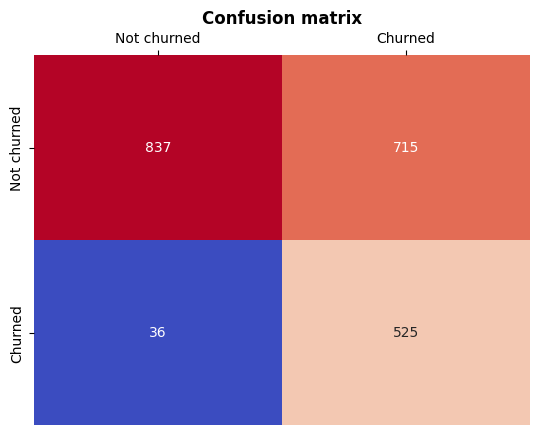

In [44]:
# make predictions 
## fbeta & classification report
val_predictions = model.predict(materials['X_test'])
val_fbeta = fbeta_score(materials['y_test'], val_predictions, 
                        beta=2)
print(f"FBeta score: {val_fbeta} \nClassification report: \n{classification_report(materials['y_test'], val_predictions)}")

## confusion matrix
data = confusion_matrix(materials['y_test'], val_predictions)
g = sns.heatmap(data, 
            annot=True, fmt='.0f', 
            cmap='coolwarm', cbar=False)
g.xaxis.tick_top()
g.set_xticklabels(['Not churned', 'Churned'])
g.set_yticklabels(['Not churned', 'Churned'])
g.set_title(label='Confusion matrix', 
            fontdict=dict(weight='bold'))

plt.show()